In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sbs
import numpy as np

spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "2g")
    .config("spark.executer.memory", "4g")
    .getOrCreate()
)

22/09/08 10:37:40 WARN Utils: Your hostname, Luo resolves to a loopback address: 127.0.1.1; using 172.30.203.116 instead (on interface eth0)
22/09/08 10:37:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/08 10:37:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
path1 = '../data/tables/transactions_20210228_20210827_snapshot/'
path2 = '../data/tables/transactions_20210828_20220227_snapshot/'

In [3]:
sdf = spark.read.parquet(path1)

In [4]:
sdf = sdf.union(spark.read.parquet(path2))

In [5]:
sdf.count()

8151372

In [6]:
sdf = sdf.withColumn("is_weekend", dayofweek("order_datetime").isin([1,7]).cast("int"))\
    .withColumn("DoW", dayofweek("order_datetime").cast('int'))

In [7]:
cleaned_sdf = sdf.withColumn('dollar_value', round(F.col('dollar_value'),2))

In [8]:
cleaned_sdf = cleaned_sdf.where(F.col('dollar_value') > 0)

In [9]:
log_sdf = cleaned_sdf.withColumn('log(dollar)', log(F.col('dollar_value')))

In [ ]:
log_sdf

In [24]:
log_sdf.select('dollar_value').describe()

summary,dollar_value
count,8151072
mean,166.3537283046945
stddev,520.3563312381578
min,0.01
max,105193.89


In [25]:
log_sdf.select('log(dollar)').describe()

summary,log(dollar)
count,8151072
mean,4.106819325258476
stddev,1.4366858596077556
min,-4.605170185988091
max,11.563560497751139


In [29]:
log_sdf.where((F.col('log(dollar)') < 4 + 2*1.44) & (F.col('log(dollar)') > 4 - 2*1.44)).count() / log_sdf.count()

0.9513738806380314

In [35]:
4 + 2*1.44

6.88

In [38]:
mean_merchant = log_sdf.select('dollar_value', 'merchant_abn').groupby('merchant_abn').mean()

In [52]:
mean_merchant.where((F.col('avg(dollar_value)') < 1000)  & (F.col('avg(dollar_value)') > 950)).count()

39

In [51]:
log_sdf.where(F.col('merchant_abn') == 56395390867)

user_id,merchant_abn,dollar_value,order_id,order_datetime,is_weekend,DoW,log(dollar)
18482,56395390867,895.05,26f35188-1b71-420...,2021-08-22,1,1,6.7968795826362
21035,56395390867,1508.15,e7a43f46-db63-46e...,2021-08-14,1,7,7.31863901311716
10141,56395390867,992.75,c2a99e49-44b0-4f9...,2021-06-17,0,5,6.90047887001136
16083,56395390867,844.54,b3aa2a17-9e57-44b...,2021-08-12,0,5,6.738792100431068
23878,56395390867,1256.96,6c03da79-9cfe-406...,2021-08-01,1,1,7.136451386285992
8422,56395390867,2080.57,746e89be-93ac-413...,2021-06-06,1,1,7.640397173615222
17439,56395390867,1316.2,4043ba7f-2b33-4ab...,2021-04-11,1,1,7.182504076022019
6751,56395390867,2256.83,4ba089bb-d5bc-4b9...,2021-04-19,0,2,7.721716452757888
6740,56395390867,240.88,6f041370-0d90-446...,2021-03-30,0,3,5.484298884173478
14288,56395390867,247.7,96355bee-2c10-472...,2021-11-28,1,1,5.512218336495314


In [11]:
log_cost = log_sdf.select('log(dollar)').toPandas()

In [21]:
sbs.set(rc={'figure.figsize':(11.7,8.27)})
sbs.set_style('darkgrid')
sbs.set(font_scale=1.3)

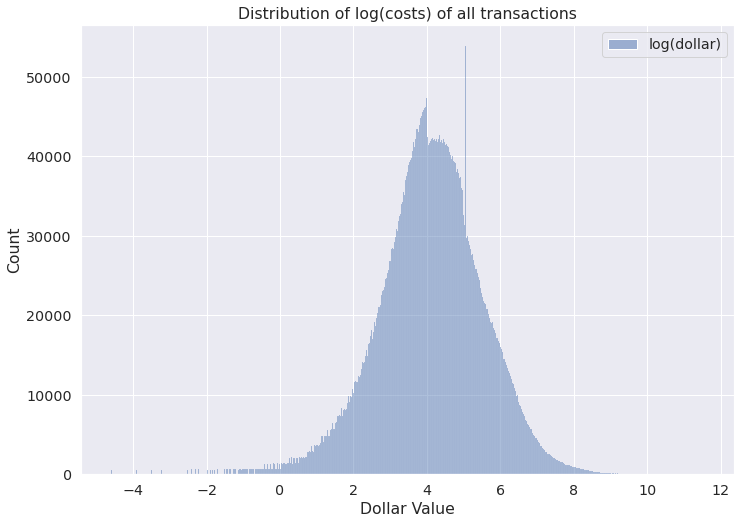

In [35]:
fig = sbs.histplot(log_cost)
fig.set_title("Distribution of log(costs) of all transactions")
fig.set_xlabel('Dollar Value')
fig = fig.get_figure()
fig.savefig('../plots/Distribution of log(costs) of all transactions.png')

In [11]:
log_sdf.write.mode('overwrite').parquet("../data/curated/transaction cleaned without remove outlier.parquet")

22/09/08 10:39:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers
22/09/08 10:39:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers
22/09/08 10:39:10 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 84.45% for 16 writers


22/09/08 10:39:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers


22/09/08 10:39:14 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 84.45% for 16 writers
22/09/08 10:39:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers
22/09/08 10:39:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers


22/09/08 10:39:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers
22/09/08 10:39:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers
22/09/08 10:39:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 84.45% for 16 writers
22/09/08 10:39:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers


22/09/08 10:39:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers


22/09/08 11:05:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1024698 ms exceeds timeout 120000 ms
22/09/08 11:05:32 WARN SparkContext: Killing executors is not supported by current scheduler.


In [18]:
merchant_total = log_sdf.select('dollar_value', 'merchant_abn').groupby('merchant_abn').sum().drop('sum(merchant_abn)').toPandas()

In [19]:
merchant_total

,merchant_abn,sum(dollar_value)
0,38700038932,5526989.11
1,83412691377,286974.12
2,15613631617,324800.21
3,19839532017,68609.00
4,73256306726,871696.30
...,...,...
4409,80664157260,20669.60
4410,50532670634,36416.00
4411,18261886835,13893.96
4412,64094501963,18365.76


Text(0.5, 0, 'Dollar Value')

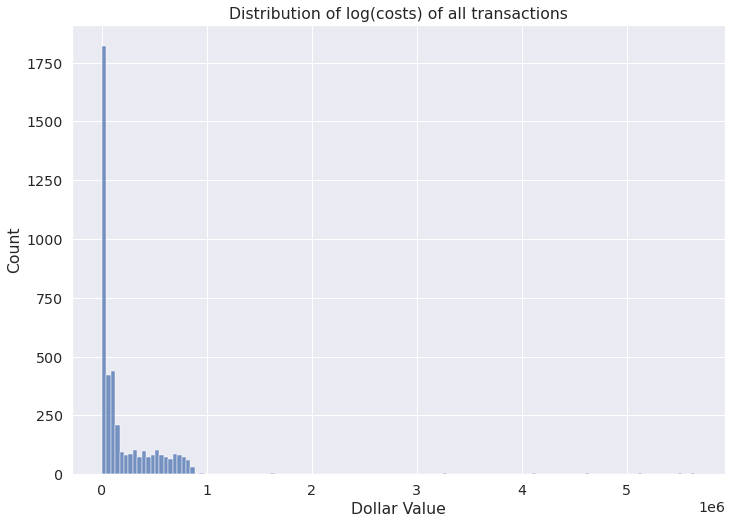

In [23]:
fig = sbs.histplot(merchant_total['sum(dollar_value)'])
fig.set_title("Distribution of log(costs) of all transactions")
fig.set_xlabel('Dollar Value')
#fig = fig.get_figure()
#fig.savefig('../plots/Distribution of log(costs) of all transactions.png')

In [13]:
log_sdf = log_sdf.where((F.col('log(dollar)') < 7) & (F.col('log(dollar)') > 1))

In [14]:
log_sdf.write.mode('overwrite').parquet("../data/curated/transaction cleaned.parquet")

22/09/07 23:14:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers
22/09/07 23:14:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers
22/09/07 23:14:13 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 84.45% for 16 writers


22/09/07 23:14:15 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers


22/09/07 23:14:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 84.45% for 16 writers
22/09/07 23:14:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers
22/09/07 23:14:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 84.45% for 16 writers
22/09/07 23:14:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers
22/09/07 23:14:16 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers


22/09/07 23:14:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers
22/09/07 23:14:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers
22/09/07 23:14:17 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 84.45% for 16 writers
22/09/07 23:14:18 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 90.08% for 15 writers


22/09/07 23:14:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,813,485,955 bytes) of heap memory
Scaling row group sizes to 96.51% for 14 writers


In [15]:
weekday_count = log_sdf.groupBy('is_weekend').count().toPandas()

In [16]:
weekday_count

,is_weekend,count
0,1,2288287
1,0,5525244


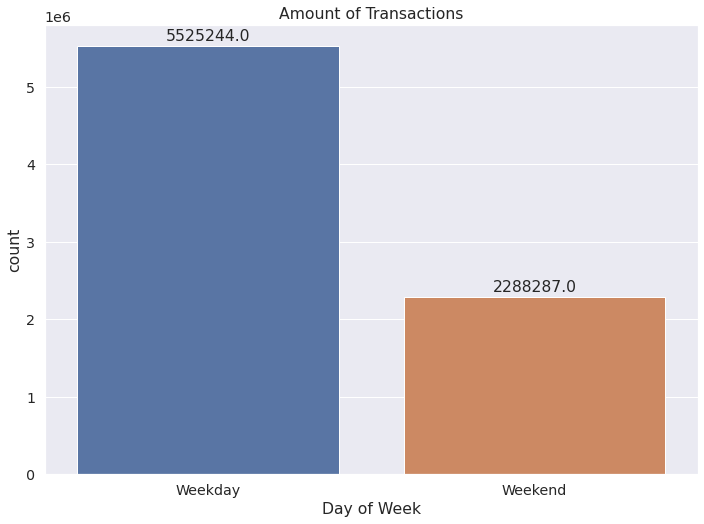

In [18]:
fig = sbs.barplot(x = 'is_weekend', y = 'count', data = weekday_count)
fig.set_xticklabels(['Weekday', 'Weekend'])
fig.set_xlabel("Day of Week")
fig.set_title("Amount of Transactions")
for p in fig.patches:
    fig.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Amount of Transactions Weekday vs Weekend.png')

In [19]:
dow_count = log_sdf.groupby('DoW').count().toPandas()

In [20]:
dow_count

,DoW,count
0,1,1156887
1,6,1167570
2,5,1122561
3,7,1131400
4,2,1104056
5,4,1070270
6,3,1060787


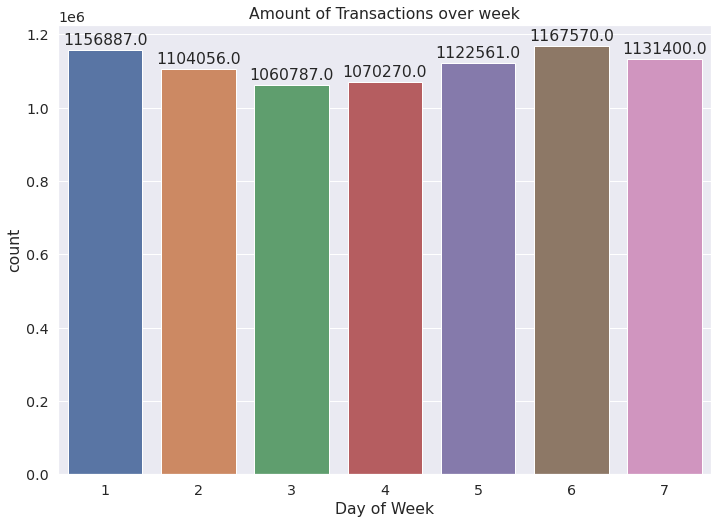

In [21]:
fig = sbs.barplot(x = 'DoW', y = 'count', data = dow_count)
fig.set_xlabel("Day of Week")
fig.set_title("Amount of Transactions over week")
for p in fig.patches:
    fig.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Amount of Transactions over week.png')

In [22]:
day_count = log_sdf.groupBy('order_datetime').count().toPandas()

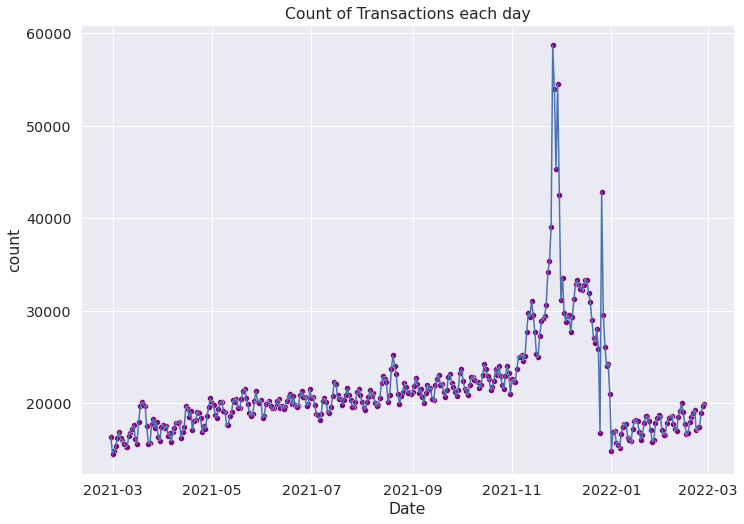

In [23]:
fig = sbs.lineplot(x = 'order_datetime', y = 'count', data = day_count)
sbs.scatterplot(x = 'order_datetime', y = 'count', data = day_count, color = 'purple')
fig.set_xlabel('Date')
fig.set_title('Count of Transactions each day')
fig = fig.get_figure()
fig.savefig('../plots/Count of Transactions each day.png')

In [24]:
dow_mean = log_sdf.select('dollar_value', 'DoW').groupby('DoW').mean().toPandas()

In [25]:
dow_mean

,DoW,avg(dollar_value),avg(DoW)
0,1,125.169722,1.0
1,6,124.922386,6.0
2,5,125.201190,5.0
3,7,125.109833,7.0
4,2,125.099289,2.0
5,4,125.258620,4.0
6,3,125.050460,3.0


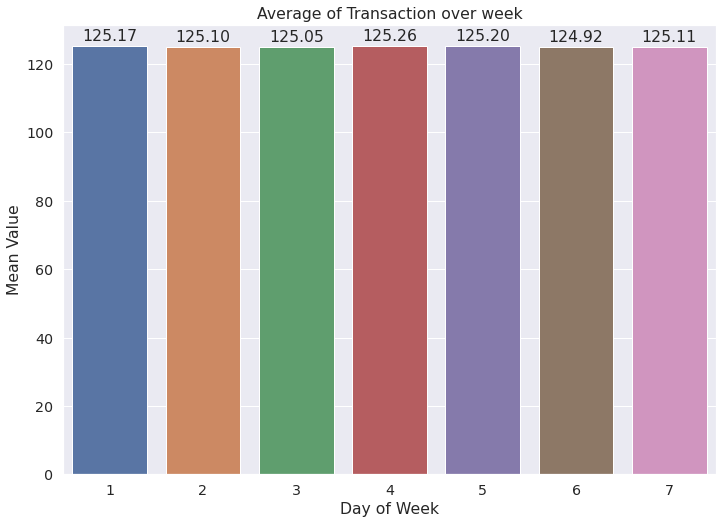

In [26]:
fig = sbs.barplot(x = 'DoW', y = 'avg(dollar_value)', data = dow_mean)
fig.set_xlabel("Day of Week")
fig.set_ylabel("Mean Value")
fig.set_title("Average of Transaction over week")
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
fig = fig.get_figure()
fig.savefig('../plots/Average of Transaction over week.png')

In [27]:
day_mean = log_sdf.select('dollar_value', 'order_datetime').groupBy('order_datetime').mean().toPandas()

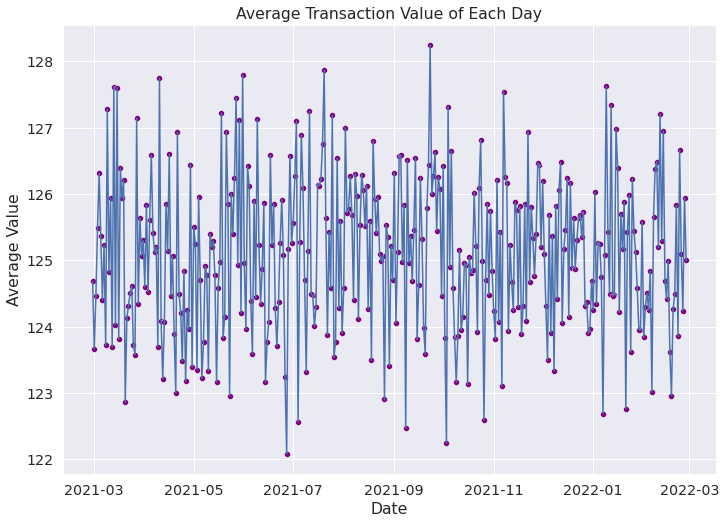

In [28]:
fig = sbs.lineplot(x = 'order_datetime', y = 'avg(dollar_value)', data = day_mean)
sbs.scatterplot(x = 'order_datetime', y = 'avg(dollar_value)', data = day_mean, color = 'purple')
fig.set_xlabel('Date')
fig.set_ylabel('Average Value')
fig.set_title("Average Transaction Value of Each Day")
fig = fig.get_figure()
fig.savefig('../plots/Average Transaction Value of Each Day.png')

In [29]:
cluster_df = cleaned_sdf \
    .groupby('merchant_abn') \
    .agg(F.expr('percentile(dollar_value, array(0.5))')[0].alias('median')) \
    .toPandas()

In [30]:
cluster_df

,merchant_abn,median
0,10023283211,187.555
1,10346855916,1532.380
2,10385163239,331.410
3,10648956813,64.480
4,10714068705,98.875
...,...,...
4409,98527912956,172.560
4410,98850646791,2938.660
4411,99009287608,141.720
4412,99420575685,2397.185


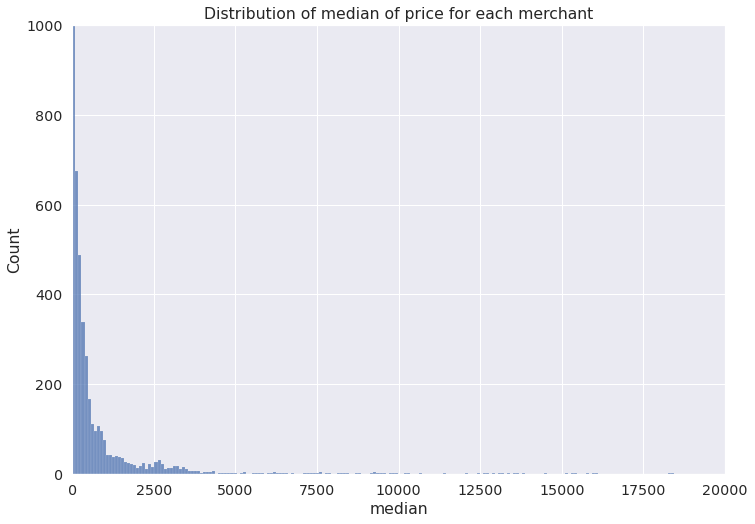

In [31]:
fig = sbs.histplot(cluster_df['median'])
fig.set_xlim(0, 20000)
fig.set_ylim(0, 1000)
fig.set_title("Distribution of median of price for each merchant")
fig = fig.get_figure()
fig.savefig('../plots/Distribution of median of price for each merchant.png')

In [32]:
cost = cleaned_sdf.select('dollar_value').toPandas()

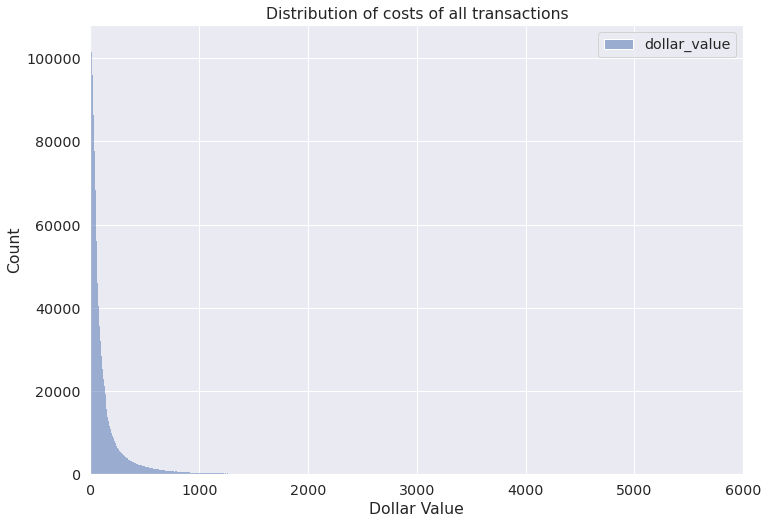

In [33]:
fig = sbs.histplot(cost)
fig.set_xlim(0, 6000)
fig.set_title("Distribution of costs of all transactions")
fig.set_xlabel('Dollar Value')
fig = fig.get_figure()
fig.savefig('../plots/Distribution of costs of all transactions.png')